In [86]:
import tensorflow as tf
from tensorflow.keras import models, layers
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers.convolutional import*

from tensorflow.keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.layers import BatchNormalization

import matplotlib.pyplot as plt
import numpy as np
import os

# EDA

In [87]:
HEIGHT = 384
WIDTH = 512

In [88]:
dataset = tf.keras.utils.image_dataset_from_directory(
    'data',
    shuffle=True,
    image_size = (HEIGHT, WIDTH),
    batch_size = BATCH_SIZE
)

Found 933 files belonging to 4 classes.


In [89]:
len(dataset)

94

In [90]:
class_names = dataset.class_names
class_names

['compost', 'e-waste', 'recycle', 'trash']

In [91]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)

# output: 10 images in batch, each image is 512x384, 3 color channels (RGB)

(10, 384, 512, 3)


In [92]:
for image_batch, label_batch in dataset.take(1):
    print(label_batch)

# output: the class labels for the first 10 images

tf.Tensor([1 3 2 0 1 2 2 3 0 0], shape=(10,), dtype=int32)


In [93]:
def display_first_ten_images():
    
    plt.figure(figsize=(10,10))
    for image_batch, label_batch in dataset.take(1):
        for i in range(10):
            ax = plt.subplot(2,5,i+1)
            plt.imshow(image_batch[i].numpy().astype(int))
            plt.title(class_names[label_batch[i]])
            plt.axis('off')

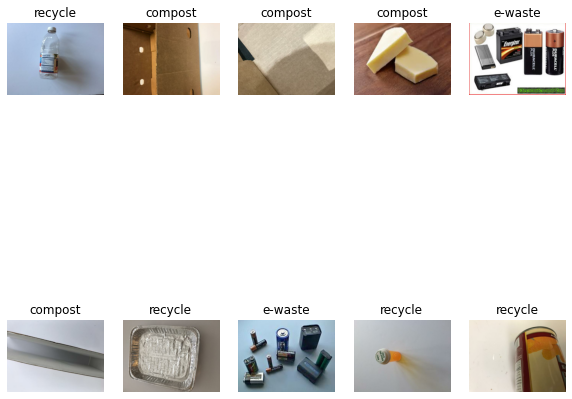

In [94]:
display_first_ten_images()

### create labels.txt file (needed for tf-lite and flutter)

In [59]:
train_gen = datagen.flow_from_directory(
    './data',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    subset='training'
)

print(train_gen.class_indices)
labels = '\n'.join(sorted(train_gen.class_indices.keys())) 
with open('labels.txt', 'w') as f: 
    f.write(labels)

{'compost': 0, 'e-waste': 1, 'recycle': 2, 'trash': 3}


### Create train-test-validation split

In [95]:
def create_train_test_validation_splits(data, shuffle=True, shuffle_size=10000):
    
    # shuffle data before splitting data
    if shuffle:
        data = data.shuffle(shuffle_size, seed=6)
    
    train_split = 0.8
    test_split = 0.1
    val_split = 0.1
    
    train_size = int(train_split * len(data))
    test_size = int(test_split * len(data))
    
    # create partitioned datasets
    train = data.take(train_size)
    test = data.skip(train_size).take(test_size)
    val = data.skip(train_size).skip(test_size)
    
    return train, test, val

In [96]:
train, test, val = create_train_test_validation_splits(dataset)

In [97]:
print(f'train size: {len(train)} batches')
print(f'test size: {len(test)} batches')
print(f'validation size: {len(val)} batches')

train size: 75 batches
test size: 9 batches
validation size: 10 batches


# Model

In [110]:
IMAGE_SIZE = 224 # MobileNetV2 expects images of 224 × 224 pixels.
BATCH_SIZE = 10
EPOCHS = 10
INPUT_SHAPE = (None, IMAGE_SIZE, IMAGE_SIZE, 3) 

In [111]:
pre_trained_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

pre_trained_model.trainable=False

In [112]:
# create pre-processing pipeline

prepoc = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    #layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [113]:
model = Sequential([
    prepoc,
    pre_trained_model,
    Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=INPUT_SHAPE),
    MaxPooling2D((2,2)),
    Flatten(),
    #BatchNormalization(axis=1),
    Dense(len(class_names), activation='softmax')
])

In [114]:
model.build(input_shape=INPUT_SHAPE)

In [115]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [116]:
history = model.fit(
    train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val
)

Epoch 1/10
75/75 [==============================] - 25s 285ms/step - loss: 1.0030 - accuracy: 0.6218 - val_loss: 0.5292 - val_accuracy: 0.8600
Epoch 2/10
75/75 [==============================] - 19s 236ms/step - loss: 0.3821 - accuracy: 0.8493 - val_loss: 0.2778 - val_accuracy: 0.8900
Epoch 3/10
75/75 [==============================] - 18s 231ms/step - loss: 0.2856 - accuracy: 0.9071 - val_loss: 0.1334 - val_accuracy: 0.9400
Epoch 4/10
75/75 [==============================] - 18s 229ms/step - loss: 0.1420 - accuracy: 0.9623 - val_loss: 0.1117 - val_accuracy: 0.9500
Epoch 5/10
75/75 [==============================] - 18s 228ms/step - loss: 0.0637 - accuracy: 0.9892 - val_loss: 0.0251 - val_accuracy: 1.0000
Epoch 6/10
75/75 [==============================] - 19s 239ms/step - loss: 0.0390 - accuracy: 0.9933 - val_loss: 0.0214 - val_accuracy: 1.0000
Epoch 7/10
75/75 [==============================] - 29s 378ms/step - loss: 0.0237 - accuracy: 0.9960 - val_loss: 0.0328 - val_accuracy: 0.9900

# Model Evaluation

In [117]:
scores = model.evaluate(test)

9/9 [==============================] - 3s 207ms/step - loss: 0.0029 - accuracy: 1.0000


In [118]:
scores

[0.002865792252123356, 1.0]

In [119]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 75}

In [120]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [121]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

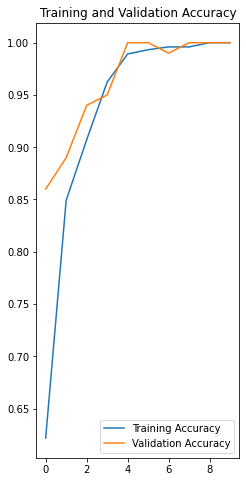

In [122]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(history.params['epochs']), acc, label='Training Accuracy')
plt.plot(range(history.params['epochs']), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

Text(0.5, 1.0, 'Training and Validation Loss')

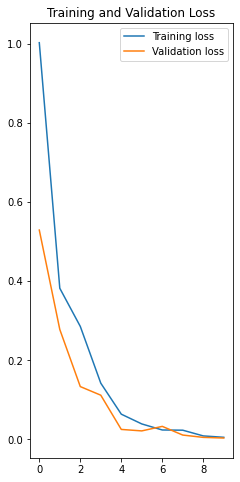

In [123]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,2)
plt.plot(range(history.params['epochs']), loss, label='Training loss')
plt.plot(range(history.params['epochs']), val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Saving the model and using TensorFlow Lite

In [126]:
model_version = 3

In [127]:
saved_model_dir = f"/Users/chaninderrishi/Desktop/smartapp/models/prod{model_version}"
model.save(saved_model_dir)

INFO:tensorflow:Assets written to: /Users/chaninderrishi/Desktop/smartapp/models/prod3/assets


INFO:tensorflow:Assets written to: /Users/chaninderrishi/Desktop/smartapp/models/prod3/assets


In [129]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

with open(f"model_tflite_{model_version}", "wb") as f:
    f.write(tflite_model)

2022-08-15 16:52:45.671988: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-08-15 16:52:45.672014: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-08-15 16:52:45.672252: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /Users/chaninderrishi/Desktop/smartapp/models/prod3
2022-08-15 16:52:45.719189: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-08-15 16:52:45.719222: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /Users/chaninderrishi/Desktop/smartapp/models/prod3
2022-08-15 16:52:45.877906: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-08-15 16:52:46.409025: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /Users/chaninderrishi/Desktop/smartapp/models/prod3
2022-08-15 16:52:46.623915: I tenso